In [102]:
!pip install sentence-transformers
!pip install "elasticsearch>=8.0.0,<9.0.0"
from elasticsearch import Elasticsearch
import pandas as pd
from sentence_transformers import SentenceTransformer
import json

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [3]:
es = Elasticsearch("http://elasticsearch:9200")
print(es.info().body["version"])

{'number': '8.7.0', 'build_flavor': 'default', 'build_type': 'docker', 'build_hash': '09520b59b6bc1057340b55750186466ea715e30e', 'build_date': '2023-03-27T16:31:09.816451435Z', 'build_snapshot': False, 'lucene_version': '9.5.0', 'minimum_wire_compatibility_version': '7.17.0', 'minimum_index_compatibility_version': '7.0.0'}


In [4]:
def similares_por_contenido(title: str, topic_or_desc: str = "", size: int = 10):
    # Cargar el modelo de sentence-transformers
    model = SentenceTransformer('all-MiniLM-L6-v2')
    
    # Combinar título y topic/descripción para la consulta
    query_text = f"{title} {topic_or_desc}" if topic_or_desc else title
    
    # Generar el embedding para el texto de consulta
    query_embedding = model.encode([query_text])[0].tolist()
    
    # Buscar videos similares usando knn
    query = {
        "knn": {
            "field": "title_embedding",
            "query_vector": query_embedding,
            "k": size,
            "num_candidates": 100
        },
        "_source": ["id", "title_raw", "topic", "language", "duration_seconds",
                   "view_count", "like_count", "published_at", "id_channel"]
    }
    
    res = es.search(
        index="videos",
        body=query,
    )
    
    rows = [{"score": h["_score"], **h["_source"]} for h in res["hits"]["hits"]]
    return pd.DataFrame(rows)

# Ejemplo de uso
df = similares_por_contenido("Introducción a matrices", "álgebra lineal, operaciones básicas", size=15)
df.head()

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

,score,id,title_raw,duration_seconds,topic,published_at,view_count,like_count,language,id_channel
0,0.786194,Ip3X9LOh2dk,"The determinant | Chapter 6, Essence of linear...",603,"3blue1brown is a channel about animating math,...",2016-08-10T22:31:18,4453029,97837,en-US,UCYO_jab_esuFRV4b17AJtAw
1,0.784768,XkY2DOUCWMU,Matrix multiplication as composition | Chapter...,604,No summary avaliable,2016-08-08T22:20:43,3892855,80327,en-US,UCYO_jab_esuFRV4b17AJtAw
2,0.764902,kYB8IZa5AuE,Linear transformations and matrices | Chapter ...,659,"3blue1brown is a channel about animating math,...",2016-08-07T21:39:19,6271357,133201,en-US,UCYO_jab_esuFRV4b17AJtAw
3,0.758695,TgKwz5Ikpc8,"Abstract vector spaces | Chapter 16, Essence o...",1006,"3blue1brown is a channel about animating math,...",2016-09-24T19:29:09,1621181,57233,en-US,UCYO_jab_esuFRV4b17AJtAw
4,0.748643,uQhTuRlWMxw,"Inverse matrices, column space and null space ...",729,"3blue1brown is a channel about animating math,...",2016-08-15T22:00:22,3425897,70835,en-US,UCYO_jab_esuFRV4b17AJtAw


In [5]:
df[["score", "title_raw"]]

,score,title_raw
0,0.786194,"The determinant | Chapter 6, Essence of linear..."
1,0.784768,Matrix multiplication as composition | Chapter...
2,0.764902,Linear transformations and matrices | Chapter ...
3,0.758695,"Abstract vector spaces | Chapter 16, Essence o..."
4,0.748643,"Inverse matrices, column space and null space ..."
5,0.746545,Essence of linear algebra preview
6,0.742173,Nonsquare matrices as transformations between ...
7,0.726094,"Vectors | Chapter 1, Essence of linear algebra"
8,0.719818,"Eigenvectors and eigenvalues | Chapter 14, Ess..."
9,0.717138,Three-dimensional linear transformations | Cha...


In [6]:
es.indices.get_mapping(index="comments")

ObjectApiResponse({'comments': {'mappings': {'properties': {'comment_embedding': {'type': 'dense_vector', 'dims': 384, 'index': True, 'similarity': 'cosine'}, 'id': {'type': 'keyword'}, 'id_video': {'type': 'keyword'}, 'like_count': {'type': 'integer'}, 'published_at': {'type': 'date'}, 'sentiment_score': {'type': 'integer'}, 'text': {'type': 'text', 'analyzer': 'standard'}}}}})

In [7]:
es.indices.get_mapping(index="videos")

ObjectApiResponse({'videos': {'mappings': {'properties': {'description': {'type': 'text', 'analyzer': 'standard'}, 'description_embedding': {'type': 'dense_vector', 'dims': 384, 'index': True, 'similarity': 'cosine'}, 'duration_seconds': {'type': 'integer'}, 'id': {'type': 'keyword'}, 'id_channel': {'type': 'keyword'}, 'language': {'type': 'keyword'}, 'like_count': {'type': 'integer'}, 'published_at': {'type': 'date'}, 'title_embedding': {'type': 'dense_vector', 'dims': 384, 'index': True, 'similarity': 'cosine'}, 'title_raw': {'type': 'text', 'fields': {'keyword': {'type': 'keyword'}}, 'analyzer': 'standard'}, 'topic': {'type': 'text', 'analyzer': 'standard'}, 'topic_embedding': {'type': 'dense_vector', 'dims': 384, 'index': True, 'similarity': 'cosine'}, 'view_count': {'type': 'integer'}}}}})

In [107]:
with open('unique_video_ids.json', 'r') as f:
    global available_video_ids = json.load(f)
#available_video_ids

In [108]:
def get_videos(es: Elasticsearch, size: int):
    """
    Busca videos en Elasticsearch y devuelve un DataFrame con ID y título.
    """
    
    ids = available_video_ids[:size]
    search_body = {
        "query": {
            # Usamos 'terms' en lugar de 'match_all'
            "terms": {
                # El campo a buscar es 'id' (el campo de tu documento)
                "id": ids 
            }
        },
        "size": size, # El tamaño se mantiene para limitar los resultados
        # Limitar los campos devueltos
        "_source": ["id", "title_raw"] 
        }

    try:
        # 2. Ejecutar la búsqueda
        response = es.search(index="videos", body=search_body)

        # 3. Procesar los resultados (hits)
        hits = response.get('hits', {}).get('hits', [])

        # 4. Construir la lista de diccionarios para el DataFrame
        rows = []
        for hit in hits:
            # Creamos un diccionario con las columnas que queremos
            row = {
                # Los campos extraídos de _source
                "id_video": hit['_source']['id'],
                "title_raw": hit['_source']['title_raw']
            }
            rows.append(row)

        # 5. Crear y devolver el DataFrame
        return pd.DataFrame(rows)

    except Exception as e:
        print(f"⚠️ Ocurrió un error al buscar videos: {e}")
        return pd.DataFrame() # Devuelve un DataFrame vacío en caso de error
df = get_videos(es, size=5)
df.head()

,id_video,title_raw
0,XX7PdJIGiCw,"If you don't understand this, you don't unders..."
1,kh9OmFBg8qI,How To See Atoms
2,tWRyiCP17do,Why didn't this skateboard stunt start from th...
3,h830G5mkTF4,How To Solve a Quadratic Equation
4,S7xvqDUPoJo,Renting A Helicopter To Settle A Physics Debate


In [117]:
def video_mas_similar(title: str):
    # Cargar el modelo de sentence-transformers
    model = SentenceTransformer('all-MiniLM-L6-v2')
    
    # Generar el embedding para el texto de consulta
    query_embedding = model.encode([title])[0].tolist()

    # Tu query debe tener esta estructura:
    query = {
        "knn": { 
            "field": "title_embedding",
            "query_vector": query_embedding,
            "k": 2,
            "num_candidates": 100,
            "filter": {
                "terms": {
                    "id": available_video_ids
                }
            }
        },
        "_source": ["id", "title_raw"]
    }
    
    res = es.search(
        index="videos",
        body=query,
    )
    
    rows = [{"score": h["_score"], **h["_source"]} for h in res["hits"]["hits"] if h["_score"] != 1.0]
    return pd.DataFrame(rows)

# Ejemplo de uso
similar_video = video_mas_similar(df['id_video'][2]).iloc[0]
similar_video

score                            0.65525
id                           R7p-nPg8t_g
title_raw    3blue1brown channel trailer
Name: 0, dtype: object

In [10]:
similar_video['title_raw']

'3blue1brown channel trailer'

In [11]:
similar_video['id']

'R7p-nPg8t_g'

In [99]:
def obtener_comentarios_por_video(es_client, video_id):
    """
    Busca y retorna todos los comentarios para un ID de video específico.
    """
    # 2. Definir el cuerpo de la consulta (Query DSL)
    search_body = {
        "query": {
            # Usamos 'term' para una coincidencia exacta con el ID
            "term": {
                "id_video": video_id
            }
        },
        # Establecemos un tamaño grande para obtener la mayoría de los comentarios.
        # Si hay millones, se necesitaría la API 'scroll' o 'search_after'.
        "size": 10000 # <-- Ajusta este límite si tienes más de 1000 comentarios
    }

    try:
        # 3. Ejecutar la búsqueda
        response = es_client.search(index="comments", body=search_body)
        
        # 4. Procesar la respuesta
        total_hits = response['hits']['total']['value']
        hits = response['hits']['hits']
        
        print(f"--- Encontrados {total_hits} comentarios para el video ID: {video_id} ---")
        
        # Extraer solo el contenido de los comentarios (_source)
        comentarios = [hit['_source']['comment_embedding'] for hit in hits]
        
        # 5. Retornar o mostrar los resultados
        return {video_id: comentarios}

    except Exception as e:
        print(f"⚠️ Ocurrió un error al buscar comentarios: {e}")
        return []

# Ejemplo de uso
video_comentarios_emb = obtener_comentarios_por_video(es, similar_video['id'])
#video_comentarios_emb

--- Encontrados 20 comentarios para el video ID: R7p-nPg8t_g ---


In [17]:
def get_comments(es: Elasticsearch, size: int):
    """
    Busca videos en Elasticsearch y devuelve un DataFrame con ID y título.
    """
    # 1. Cuerpo de la consulta
    search_body = {
        "query": {
            "match_all": {}
        },
        "size": size,
        # Opcional pero útil: limitar los campos devueltos para ahorrar ancho de banda
        "_source": ["id", "comment_embedding"] 
    }

    try:
        # 2. Ejecutar la búsqueda
        response = es.search(index="comments", body=search_body)

        # 3. Procesar los resultados (hits)
        hits = response.get('hits', {}).get('hits', [])

        # 4. Construir la lista de diccionarios para el DataFrame
        rows = []
        for hit in hits:
            # Creamos un diccionario con las columnas que queremos
            row = {
                # Los campos extraídos de _source
                "id_comment": hit['_source']['id'],
                "embedding": hit['_source']['comment_embedding']
            }
            rows.append(row)

        # 5. Crear y devolver el DataFrame
        return pd.DataFrame(rows)

    except Exception as e:
        print(f"⚠️ Ocurrió un error al buscar videos: {e}")
        return pd.DataFrame() # Devuelve un DataFrame vacío en caso de error
df_comments = get_comments(es, size=100)
df_comments

,id_comment,embedding
0,UgyBUfIkQCf8wvDoTux4AaABAg,"[-0.06145951896905899, 0.09428942203521729, -0..."
1,UgyyeYhNulwEzVoNxgh4AaABAg,"[0.09146156162023544, -0.04957323893904686, -0..."
2,UgwuLjMgvWNGrF5hf3p4AaABAg,"[-0.10544253885746002, 0.08152712136507034, 0...."
3,UgzvlrCmJSrSb9d_c154AaABAg,"[-0.10131843388080597, 0.03103492595255375, -0..."
4,Ugz9xhjPZ9sStiGaL9R4AaABAg,"[-0.005349915008991957, 0.025905048474669456, ..."
...,...,...
95,UgzUI6RYvA2svuJHdEN4AaABAg,"[-0.05627152696251869, 0.03208199515938759, 0...."
96,Ugz1IbiM5rEnVFM-4Y94AaABAg,"[-0.08611934632062912, 0.09956619143486023, 0...."
97,UgywOIkb0I3WdqKkJh54AaABAg,"[-0.03725375235080719, 0.051990244537591934, 0..."
98,UgzNrjDffsJfIqiMNPF4AaABAg,"[-0.04040452092885971, 0.07924745976924896, 0...."


In [21]:
import numpy as np
from sklearn.manifold import TSNE

In [165]:
def embedding_dimensionality_reduction(embeddings):
    embs = np.array(embeddings)
    print(embs.shape)
    embs_2dims = TSNE(n_components=2, learning_rate='auto',
                  init='random', perplexity=5).fit_transform(embs)
    print(embs_2dims.shape)
    return embs_2dims

#print(list(video_comentarios_emb.values()))
video_comentarios_emb2dims = embedding_dimensionality_reduction(list(video_comentarios_emb.values())[0])

(20, 384)
(20, 2)


In [58]:
def create_dataframe(video_comentarios_emb, video_comentarios_emb2dims):
    data = []
    key = list(video_comentarios_emb.keys())[0]
    for emb in video_comentarios_emb2dims:
        data.append({'id_video': key, 'comment_emb2dims': emb})
    return pd.DataFrame(data)
df_video_emb2dims = create_dataframe(video_comentarios_emb, video_comentarios_emb2dims)
df_video_emb2dims.head()

,id_video,comment_emb2dims
0,R7p-nPg8t_g,"[-129.48657, -49.968933]"
1,R7p-nPg8t_g,"[-11.593742, -25.932148]"
2,R7p-nPg8t_g,"[16.627247, 4.584729]"
3,R7p-nPg8t_g,"[74.02974, 27.34438]"
4,R7p-nPg8t_g,"[75.089096, 60.19721]"


In [125]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def graficar_embeddings_por_id(df: pd.DataFrame, embedding_col: str, id_col: str):
    """
    Crea un gráfico de dispersión (scatter plot) a partir de embeddings 2D,
    donde el color de cada punto está determinado por el valor de una columna ID.

    :param df: El DataFrame de pandas.
    :param embedding_col: Nombre de la columna que contiene la lista [x, y] del embedding.
    :param id_col: Nombre de la columna que contiene el ID (para determinar el color).
    """
    
    print("Preparando datos para graficar...")

    # 1. Dividir la columna de embeddings [x, y] en dos columnas separadas (X y Y)
    # Esto es necesario para que Seaborn pueda mapearlas a los ejes.
    df['X'] = df[embedding_col].apply(lambda x: x[0])
    df['Y'] = df[embedding_col].apply(lambda x: x[1])

    # 2. Crear el gráfico de dispersión usando Seaborn
    plt.figure(figsize=(10, 8))
    
    # 'hue' se encarga de asignar un color único a cada valor en la columna id_col
    sns.scatterplot(
        x='X', 
        y='Y', 
        hue=id_col, 
        data=df, 
        s=100, # Tamaño de los puntos
        alpha=0.7 # Transparencia
    )
    
    # 3. Configurar y mostrar el gráfico
    plt.title(f'Visualización de Embeddings 2D coloreados por {id_col}', fontsize=16)
    plt.xlabel('Componente X del Embedding', fontsize=12)
    plt.ylabel('Componente Y del Embedding', fontsize=12)
    plt.legend(title=id_col)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

id_video                 BWA9luXDNMU
title_raw    El Presente es Relativo
Name: 2, dtype: object
id                                      Qe6o9j4IjTo
title_raw    Q&A with Grant Sanderson (3blue1brown)
Name: 0, dtype: object
--- Encontrados 20 comentarios para el video ID: BWA9luXDNMU ---
--- Encontrados 20 comentarios para el video ID: Qe6o9j4IjTo ---
(40, 384)
(40, 2)
      id_video        comment_emb2dims
0  BWA9luXDNMU  [55.432358, 18.299318]
1  BWA9luXDNMU    [55.07214, 70.34208]
2  BWA9luXDNMU  [55.177452, 50.484104]
3  BWA9luXDNMU  [40.012123, 14.484418]
4  BWA9luXDNMU   [37.617714, 40.64772]
Preparando datos para graficar...


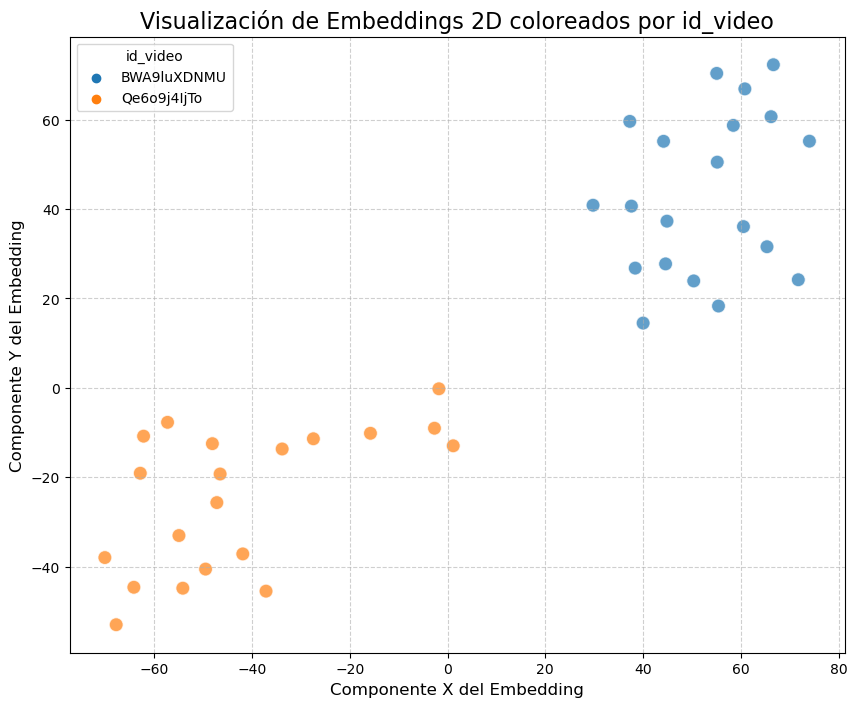

In [166]:
def compare_video_comments(es, video_iloc):
    # Get videos to compare
    video1 = get_videos(es, size=1500).iloc[video_iloc]
    print(video1)
    video2 = video_mas_similar(video1['id_video']).iloc[0][['id','title_raw']]
    print(video2)
    
    # Get embeddings
    video1_comments_embs = obtener_comentarios_por_video(es, video1['id_video'])
    video2_comments_embs = obtener_comentarios_por_video(es, video2['id'])
    
    # ABORT IF WE HAVE LESS THAN 10 COMMENTS:
    n_comments1 = len(list(video1_comments_embs.values())[0])
    n_comments2 = len(list(video2_comments_embs.values())[0])
    if n_comments1 < 10 or n_comments2 < 10:
        pass
    else:
        # Get 2 dimension embeddings
        video_comments_embd2dims = embedding_dimensionality_reduction(list(video1_comments_embs.values())[0] + list(video2_comments_embs.values())[0])
        video1_comments_emb2dims = video_comments_embd2dims[:n_comments1]
        video2_comments_emb2dims = video_comments_embd2dims[n_comments2:]

        # Transform it into a DataFrame
        df1_video_comments_emb2dims = create_dataframe(video1_comments_embs, video1_comments_emb2dims)
        df2_video_comments_emb2dims = create_dataframe(video2_comments_embs, video2_comments_emb2dims)

        df_video_comments_emb2dims = pd.concat([df1_video_comments_emb2dims, df2_video_comments_emb2dims])
        print(df_video_comments_emb2dims.head())

        return df_video_comments_emb2dims

df_video_comments_emb2dims = compare_video_comments(es, video_iloc=2)
graficar_embeddings_por_id(df_video_comments_emb2dims, 'comment_emb2dims', 'id_video')

In [185]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def graficar_embeddings_2d(df: pd.DataFrame, embedding_col: str, color_col: str, style_col: str):
    """
    Crea un gráfico de dispersión (scatter plot) a partir de embeddings 2D.

    :param df: El DataFrame de pandas.
    :param embedding_col: Nombre de la columna que contiene la lista [x, y] del embedding.
    :param color_col: Nombre de la columna para el COLOR (ej. 'id_grupo').
    :param style_col: Nombre de la columna para la FORMA (ej. 'tipo_video').
    """
    
    # 1. Preparar datos (evitar 'SettingWithCopyWarning')
    df_plot = df.copy()
    
    # 2. Dividir la columna de embeddings [x, y] en dos columnas separadas (X y Y)
    # (Asegúrate de que la 'embedding_col' contenga listas, como [20.82, -5.87])
    df_plot['X'] = df_plot[embedding_col].apply(lambda x: x[0])
    df_plot['Y'] = df_plot[embedding_col].apply(lambda x: x[1])

    # 3. Crear el gráfico de dispersión usando Seaborn
    plt.figure(figsize=(12, 10)) # Aumentamos el tamaño para la leyenda
    
    sns.scatterplot(
        x='X', 
        y='Y', 
        hue=color_col,   # <-- Color determinado por el grupo (ej. 0, 1, 2)
        style=style_col, # <-- Forma determinada por V1 o V2
        data=df_plot, 
        s=100, # Tamaño de los puntos
        alpha=0.7 
    )
    
    # 4. Configurar y mostrar el gráfico
    plt.title(f'Visualización de Embeddings 2D', fontsize=16)
    plt.xlabel('Componente X (t-SNE)', fontsize=12)
    plt.ylabel('Componente Y (t-SNE)', fontsize=12)
    plt.legend(title='Leyenda', bbox_to_anchor=(1.05, 1), loc='upper left') # Mover leyenda fuera
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout() # Ajustar para que la leyenda entre
    plt.show()

In [187]:
def compare_multiple_video_comments(es, n_tuples_of_videos_to_compare=2, id_video_randomizer=1):
    
    lista_de_datos_comentarios = []
    
    print(f"Iniciando la RECOLECCIÓN de {n_tuples_of_videos_to_compare} tuplas de videos...")

    for i in range(n_tuples_of_videos_to_compare):
        print(f"Procesando tupla de grupo {i}...")
        
        try:
            # 1. Obtener los dos videos
            video_iloc = int((i + 1) * id_video_randomizer)
            video1 = get_videos(es, size=1500).iloc[video_iloc]
            video2 = video_mas_similar(video1['id_video']).iloc[0][['id','title_raw']]
            
            print(f"  Video 1 (Original): {video1['id_video']}")
            print(f"  Video 2 (Similar):  {video2['id']}")

            # 2. Obtener embeddings (alta dimensión)
            video1_comments_embs = obtener_comentarios_por_video(es, video1['id_video'])
            video2_comments_embs = obtener_comentarios_por_video(es, video2['id'])

            # 3. Extraer listas y verificar n_comentarios
            v1_embs_list = list(video1_comments_embs.values())[0]
            v2_embs_list = list(video2_comments_embs.values())[0]
            n_comments1 = len(v1_embs_list)
            n_comments2 = len(v2_embs_list)

            if n_comments1 < 10 or n_comments2 < 10:
                print(f"  Tupla {i} saltada: pocos comentarios ({n_comments1} y {n_comments2})")
                continue 

            # 4. Guardar datos (¡AÑADIENDO 'tipo_video'!)
            for emb in v1_embs_list:
                lista_de_datos_comentarios.append({
                    'id_grupo': i, # El ID para el COLOR
                    'tipo_video': 'Video 1 (Original)', # El ID para la FORMA
                    'id_video_original': video1['id_video'],
                    'embedding_orig': emb
                })
            
            for emb in v2_embs_list:
                 lista_de_datos_comentarios.append({
                    'id_grupo': i, 
                    'tipo_video': 'Video 2 (Similar)', # El ID para la FORMA
                    'id_video_original': video2['id'],
                    'embedding_orig': emb
                })

        except Exception as e:
            print(f"  ERROR procesando tupla {i}: {e}")
            continue

    # --- FASE 2: FIN DEL BUCLE ---
    
    if not lista_de_datos_comentarios:
        print("No se recolectaron datos suficientes.")
        return pd.DataFrame() # Devolver DF vacío

    final_df = pd.DataFrame(lista_de_datos_comentarios)
    
    # 5. Ejecutar TSNE UNA SOLA VEZ
    todos_los_embeddings = np.array(final_df['embedding_orig'].tolist())
    print(f"\nEjecutando TSNE sobre {todos_los_embeddings.shape} embeddings...")
    
    tsne_model = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=5)
    embeddings_2d = tsne_model.fit_transform(todos_los_embeddings)
    
    print("TSNE completado. Asignando resultados.")

    # 6. Añadir los resultados 2D (la columna para el gráfico)
    final_df['comment_emb2dims'] = list(embeddings_2d)
    
    # 7. Renombrar 'id_grupo' a 'id_video' (como lo tenías antes para el color)
    final_df['id_video'] = final_df['id_grupo']
    
    # 8. Devolver las columnas necesarias
    return final_df[['id_video', 'comment_emb2dims', 'tipo_video']]

Iniciando la RECOLECCIÓN de 2 tuplas de videos...
Procesando tupla de grupo 0...
  Video 1 (Original): WKXo-jz6KjI
  Video 2 (Similar):  Oiovhx_Vx4w
--- Encontrados 20 comentarios para el video ID: WKXo-jz6KjI ---
--- Encontrados 20 comentarios para el video ID: Oiovhx_Vx4w ---
Procesando tupla de grupo 1...
  Video 1 (Original): BWA9luXDNMU
  Video 2 (Similar):  Qe6o9j4IjTo
--- Encontrados 20 comentarios para el video ID: BWA9luXDNMU ---
--- Encontrados 20 comentarios para el video ID: Qe6o9j4IjTo ---

Ejecutando TSNE sobre (80, 384) embeddings...
TSNE completado. Asignando resultados.


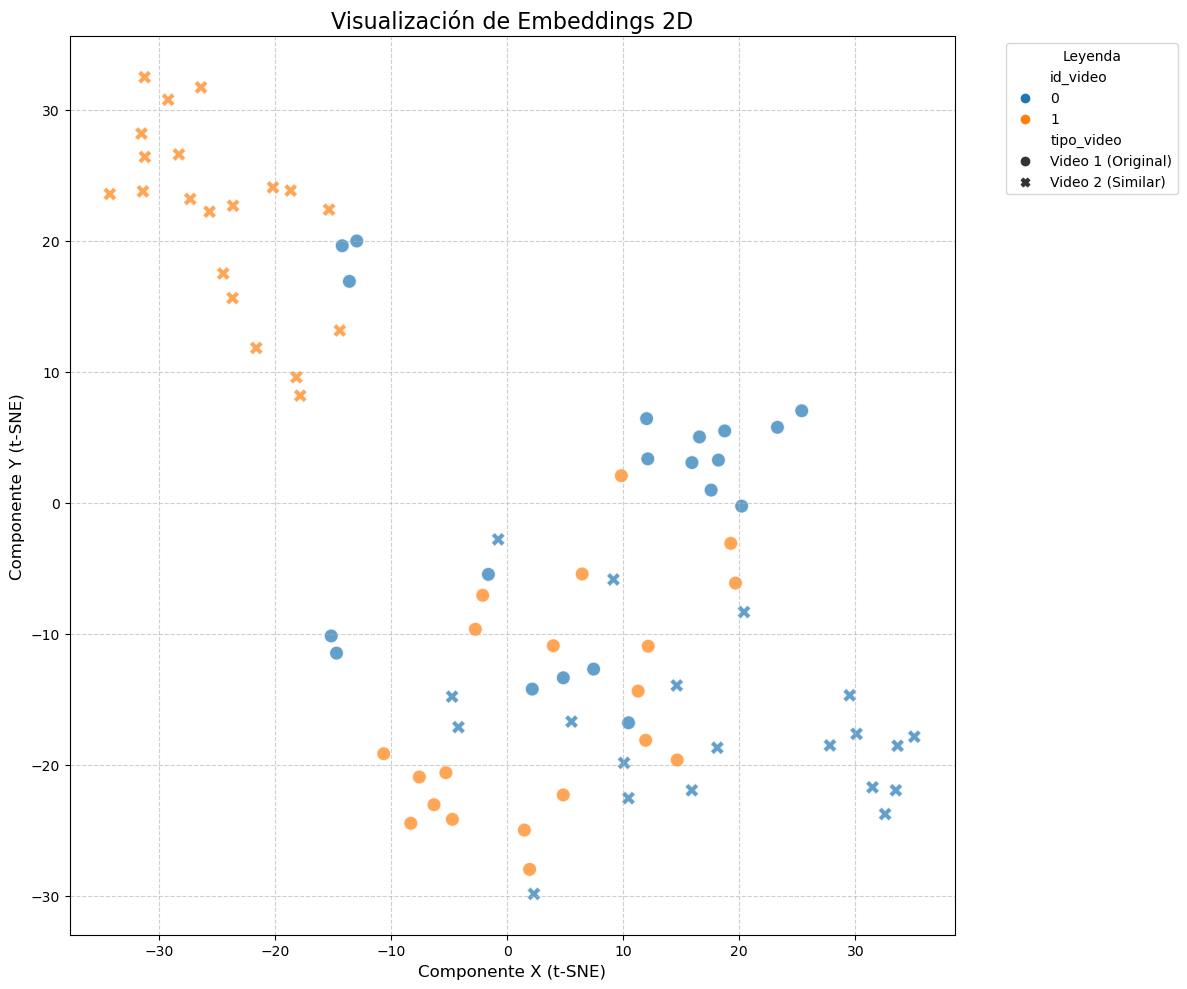

Iniciando la RECOLECCIÓN de 2 tuplas de videos...
Procesando tupla de grupo 0...
  Video 1 (Original): 4LYlMqBXTJI
  Video 2 (Similar):  w5ebcowAJD8
--- Encontrados 20 comentarios para el video ID: 4LYlMqBXTJI ---
--- Encontrados 20 comentarios para el video ID: w5ebcowAJD8 ---
Procesando tupla de grupo 1...
  Video 1 (Original): IXPx1L8rVcU
  Video 2 (Similar):  -dhHrg-KbJ0
--- Encontrados 20 comentarios para el video ID: IXPx1L8rVcU ---
--- Encontrados 20 comentarios para el video ID: -dhHrg-KbJ0 ---

Ejecutando TSNE sobre (80, 384) embeddings...
TSNE completado. Asignando resultados.


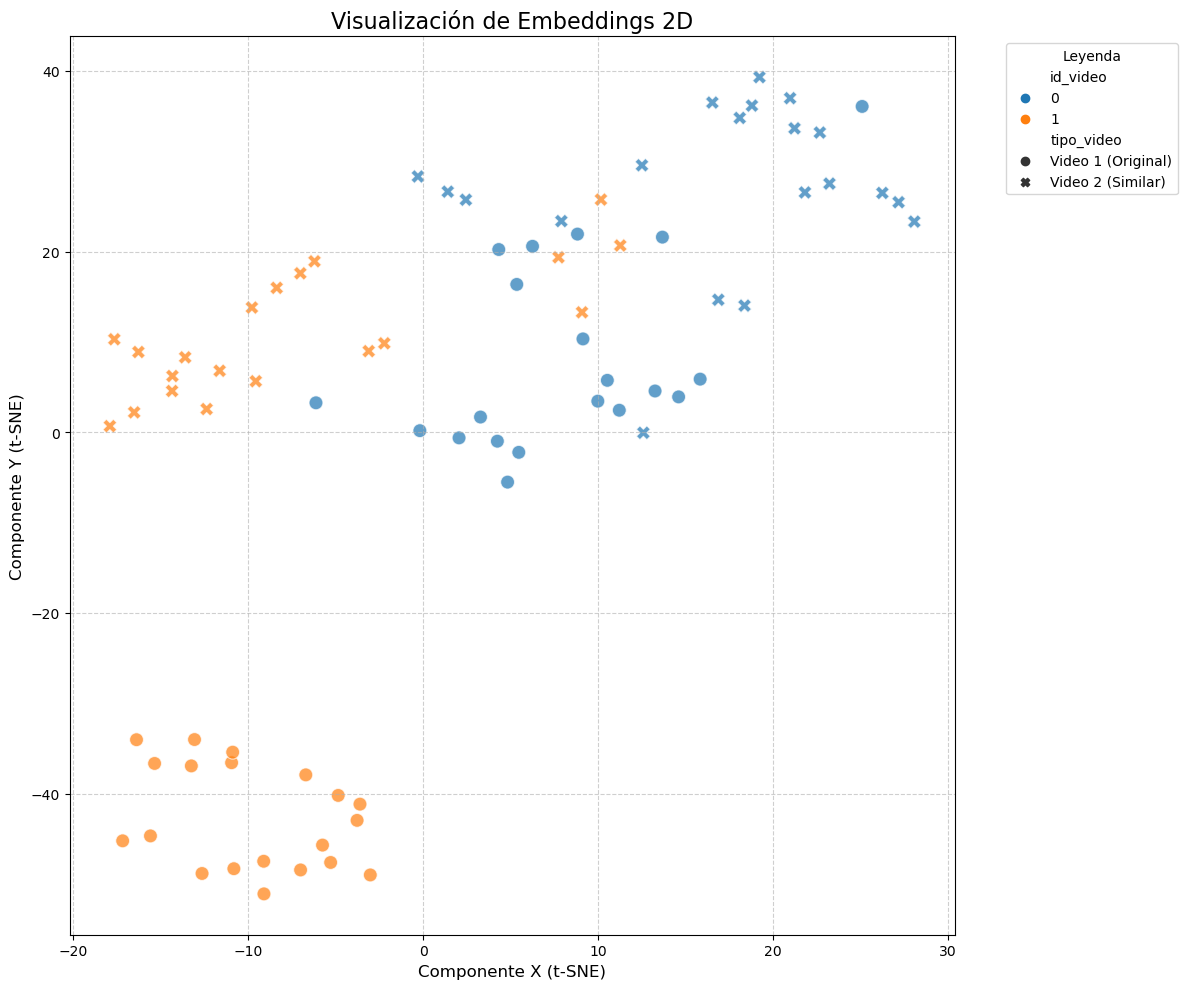

Iniciando la RECOLECCIÓN de 2 tuplas de videos...
Procesando tupla de grupo 0...
  Video 1 (Original): Is2Lip1cJUc
  Video 2 (Similar):  tRaq4aYPzCc
--- Encontrados 20 comentarios para el video ID: Is2Lip1cJUc ---
--- Encontrados 20 comentarios para el video ID: tRaq4aYPzCc ---
Procesando tupla de grupo 1...
  Video 1 (Original): C4j4BZFiGgM
  Video 2 (Similar):  He30D8M5fNc
--- Encontrados 20 comentarios para el video ID: C4j4BZFiGgM ---
--- Encontrados 20 comentarios para el video ID: He30D8M5fNc ---

Ejecutando TSNE sobre (80, 384) embeddings...
TSNE completado. Asignando resultados.


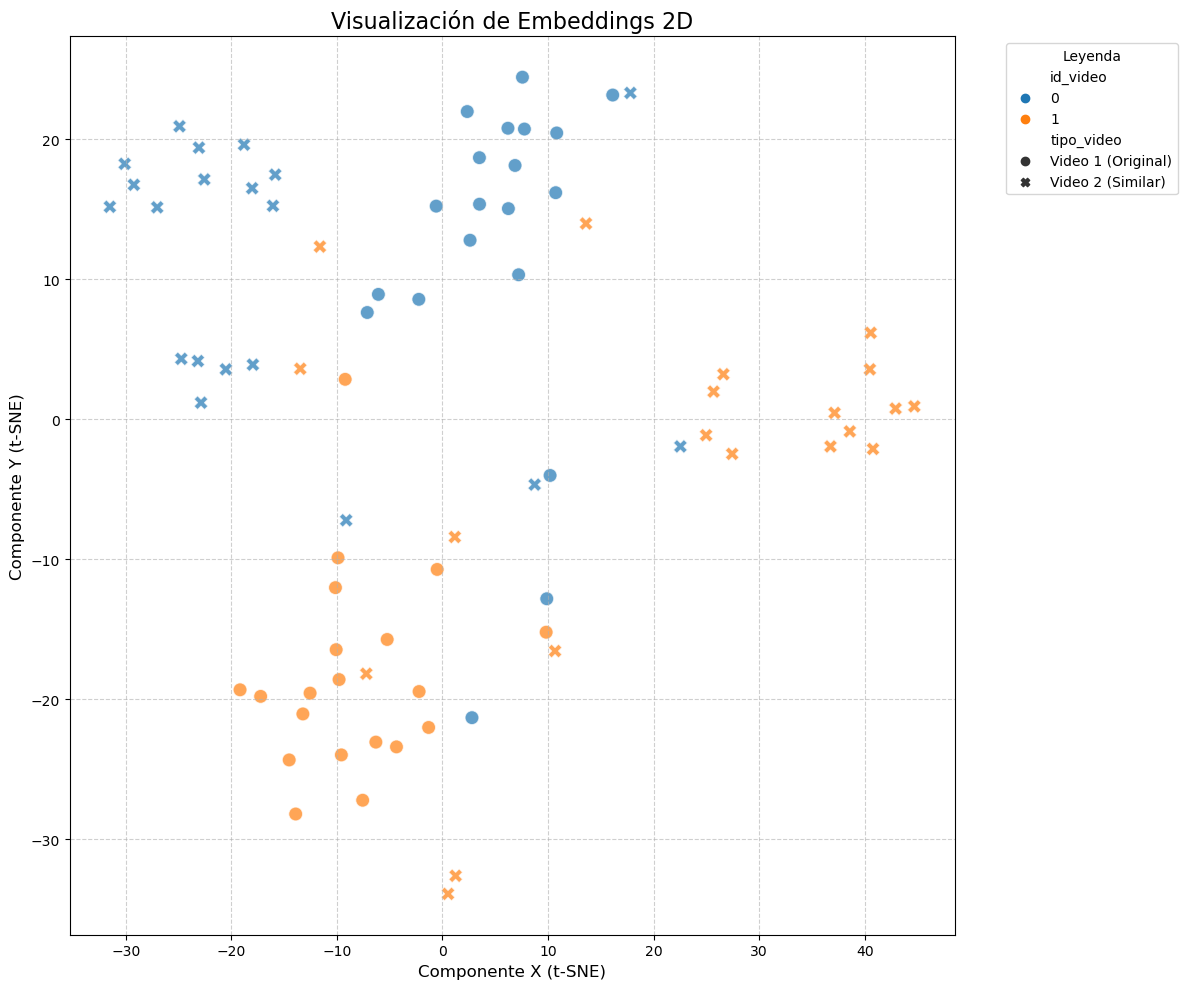

Iniciando la RECOLECCIÓN de 2 tuplas de videos...
Procesando tupla de grupo 0...
  Video 1 (Original): wBNIU8CYgAE
  Video 2 (Similar):  akIBlq5xAec
--- Encontrados 20 comentarios para el video ID: wBNIU8CYgAE ---
--- Encontrados 20 comentarios para el video ID: akIBlq5xAec ---
Procesando tupla de grupo 1...
  Video 1 (Original): TNHtwy-mnLU
  Video 2 (Similar):  xmYss_hNF4Q
--- Encontrados 20 comentarios para el video ID: TNHtwy-mnLU ---
--- Encontrados 20 comentarios para el video ID: xmYss_hNF4Q ---

Ejecutando TSNE sobre (80, 384) embeddings...
TSNE completado. Asignando resultados.


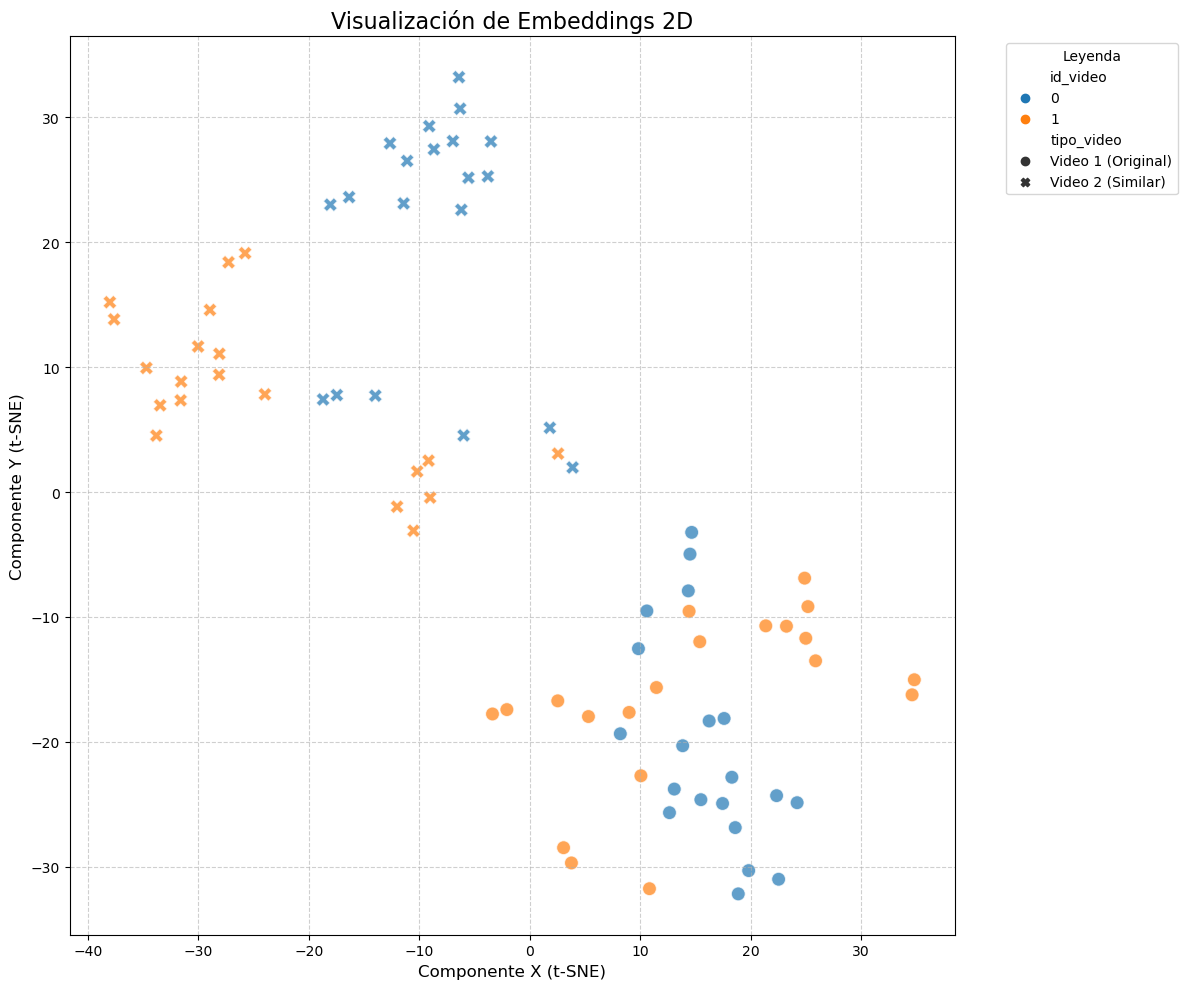

In [193]:
randomizers = [1, 5, 20, 100]
for randomizer in randomizers:
    df_para_graficar = compare_multiple_video_comments(es, n_tuples_of_videos_to_compare=2, id_video_randomizer=randomizer) 
    graficar_embeddings_2d(df=df_para_graficar, embedding_col='comment_emb2dims', color_col='id_video', style_col='tipo_video')